# <center>Demographics and Comorbidity of Behavior Problems in Dogs</center>
<center>Ian R. Dinwoodie, Vivian Zottola, Barbara Dwyer, Donna Gleason, Nicholas H. Dodman</center>

In [1]:
import sqlite3
import pandas as pd
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from scipy.stats import ttest_ind

# IPython magics for this notebook.
%matplotlib inline

# Use latex font for matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
class FieldRegistry:
    
    def __init__(self):
        self.fields = {}
        self.labels = {}
    
    def addToRegistry(self, index, labels, fields, category):
        self.labels[category] = {}
        for counter, value in enumerate(labels, 1):
            key = '{}{:02}'.format(index, counter)
            self.labels[category][key] = value
        self.fields[category] = fields
        
FR = FieldRegistry()   
CATEGORY = ['Aggression', 'Fear/Anxiety', 'Compulsion', 'House Soiling', 'Excessive Barking', 
            'Jumping', 'Mounting/Humping', 'Consuming Feces', 'Destructive Behavior',
            'Rolling in Repulsive Material', 'Running Away/Escaping', 
            'Overactivity/Hyperactivity']
        
# Aggression.
labels = ['Familiar people in the home', 'Stangers visiting the home',
          'Stangers away from the home', 'Another dog in the home',
          'Unfamiliar dogs visiting the home', 'Unfamiliar dogs on walks (off lead)',
          'Unfamiliar dogs on walks (on lead)', 'Veterinarians', 'Trainers', 'Groomers',
          'Animals other than dogs in the home']
fields = ['q03_main_1', 'q03_main_2', 'q03_main_3', 'q03_main_4', 'q03_main_5', 'q03_main_6',
          'q03_main_7', 'q03_main_8', 'q03_main_9', 'q03_main_10', 'q03_main_11']
FR.addToRegistry('A', labels, fields, CATEGORY[0])

# Fear/anxiety.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Crowd phobia', 'Phobia of other dogs',
          'PTSD', 'Generalized anxiety', 'Situational anxiety', 'Veterinarian phobia',
          'Separation anxiety', 'Travel anxiety', 'Other']
fields = ['q04_1', 'q04_2', 'q04_3', 'q04_4', 'q04_5', 'q04_6', 'q04_7', 'q04_8', 'q04_9',
          'q04_10', 'q04_11']
FR.addToRegistry('B', labels, fields, CATEGORY[1])

# Compulsion.
labels = ['Spinning', 'Tail chasing', 'Shadow/light chasing', 'Running in geometric patterns',
          'Licking of wrist/hock', 'Fly snapping', 'Sucking flank region/blankets',
          'Tennis ball fetish', 'Collecting/arranging objects', 'Nail biting',
          'Digging in yard', 'Stone/rock chewing', 'Other']
fields = ['q05_main_1', 'q05_main_2', 'q05_main_3', 'q05_main_4', 'q05_main_5', 'q05_main_6',
          'q05_main_7', 'q05_main_8', 'q05_main_9', 'q05_main_10', 'q05_main_11',
          'q05_main_12', 'q05_main_13']
FR.addToRegistry('C', labels, fields, CATEGORY[2])

# House soiling.
## soil_type = ['Urine', 'Feces', 'Urine and feces']
labels = ['Urine', 'Feces', 'Urine and feces', 'Specific locations', 'Anywhere',
          'Owner present', 'Owner away', 'Excited/overwhelmed']
fields = ['q06_soil_type_1', 'q06_soil_type_2', 'q06_soil_type_3','q06_soil_location_1',
          'q06_soil_location_2', 'q06_situation_1', 'q06_situation_2', 'q06_situation_3']
FR.addToRegistry('D', labels, fields, CATEGORY[3])

# Excessive barking.
labels = ['Owner present', 'Owner away', 'To get attention', 'At tiggers (inside)',
          'At triggers (outside)', 'During car rides']
fields = ['q07_sitatuon_1', 'q07_sitatuon_2', 'q07_sitatuon_3', 'q07_sitatuon_4',
          'q07_sitatuon_5', 'q07_sitatuon_6']
FR.addToRegistry('E', labels, fields, CATEGORY[4])

# Jumping.
labels = ['Owner', 'Family members', 'Strangers']
fields = ['q08_who_1', 'q08_who_2', 'q08_who_3']
FR.addToRegistry('F', labels, fields, CATEGORY[5])

# Mounting/humping.
labels = ['People', 'Familiar dogs', 'Unfamiliar dogs', 'Inanimate objects']
fields = ['q09_main_1', 'q09_main_2', 'q09_main_3', 'q09_main_4']
FR.addToRegistry('G', labels, fields, CATEGORY[6])

# Consuming feces.
labels = ['Their own', "Other dogs'", "Other species'"]
fields = ['q10_main_1', 'q10_main_2', 'q10_main_3']
FR.addToRegistry('H', labels, fields, CATEGORY[7])

# Destructive behavior.
labels = ['Owner is home', 'Owner is away']
fields = ['q11_situation_1', 'q11_situation_2']
FR.addToRegistry('I', labels, fields, CATEGORY[8])

# Rolling in repulsive materials.
labels = ['Urine', 'Feces', 'Dead Stuff', 'Garbage']
fields = ['q12_main_1', 'q12_main_2', 'q12_main_3', 'q12_main_4']
FR.addToRegistry('J', labels, fields, CATEGORY[9])

# Running away/escaping.
labels = ['Escapes when out', 'Escapes from home', 'Escapes from confinement',
          'Returns home after escape']
fields = ['q14_out', 'q14_house', 'q14_conf', 'q14_return']
FR.addToRegistry('K', labels, fields, CATEGORY[10])

# Overactivity/hyperactivity.
labels = ['Constant moving/jumping', 'Difficulty settling', 'Highly distractible',
          'Impulsive']
fields = ['q15_main_1', 'q15_main_2', 'q15_main_3', 'q15_main_4']
FR.addToRegistry('L', labels, fields, CATEGORY[11])

In [3]:
# Data Globals
SIG_P = 0.01
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()
QUESTION_MATRIX = pd.DataFrame()

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [4]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(PREVALENCE)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv

def checkSignificance(p, sig=SIG_P):
    if p < sig:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig)
        
def exportTable(data, title):
    file_ = os.path.join('..', 'reports', 'tables', title) + '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth=\maxdimen]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    file_ = os.path.join('..', 'reports', 'figures', title) + '.png'
    figure.tight_layout()
    figure.savefig(file_, dpi = 500)

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createCorrelationMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    return df.corr()

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1    

## 1. Participant Demographics

### Number of participants:

In [5]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('Total number of participants: %d' %TOTAL_USERS)

Total number of participants: 3201


### Motivation for enrollment:

In [6]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['Love for dogs', 'You help shelter animals', 'Suspicion of behavior problems',
          'Work with animals', 'Other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
s = df.sum(0, skipna=False)
s = s.sort_values(ascending=False)
df = pd.DataFrame(index=s.index, data={'Count':s.values})
df.columns.name = 'Motivation'
display(df)
# NOTE: This does not include a count of users who did not provide a reason.

Motivation,Count
Love for dogs,2595
You help shelter animals,1377
Work with animals,1049
Suspicion of behavior problems,830
Other,273


### Suspicion of behavior problems as sole motivating factor:

In [7]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('Number of users who reported suspicion of behavior problems as their sole motivation: %d' %(s.iloc[2]))

Number of users who reported suspicion of behavior problems as their sole motivation: 98


## 2. Participating Dog Demographics

### Number of participating dogs:

In [8]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('Total number of participating dogs: %d' %TOTAL_DOGS)

Total number of participating dogs: 5018


### Adjusting sample for bias:

It is in this section that we define and apply a filter to remove bias from the data set.
 
The current bias filter focuses largely on the participants' motivation for enrollment ("Why did you decide to participate in this survey?", pg. 1). The answer choice "my dog may have a behavior problem" was included to identify participants who enrolled with motivational bias. However, participants may not have a motiivational bias towards all of their participating dogs. To account for this, the question "do you believe \[dog name\] has ever had a behavior problem" (pg. 4) was used in conjunction with the enrollment motivation to identify the dogs most likely to be influenced by the bias of the participating owner. 

In [9]:
fields = 'q02_score'
labels = ['Score']

df_gross = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=False)
cnt_total_dogs_w_problems = len(df_gross[df_gross[labels[0]] != 0].index)

df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
cnt_total_dogs_w_problems_adjusted = len(df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]


# Display the count results.
print('Pre-adjustment Responses (Gross):')
print('Total number of owners: %d' %TOTAL_USERS)
print('Total number of dogs: %d' %TOTAL_DOGS)
print('Total number of dogs with a reported behavior problem: %d' %cnt_total_dogs_w_problems)

print('\nPost-adjustment Responses (Adjusted):')
print('Total number of owners: %d' %REMAINING_USERS)
print('Total number of dogs: %d' %REMAINING_DOGS)
print('Total number of dogs with a reported behavior problem: %d'
      %cnt_total_dogs_w_problems_adjusted)

Pre-adjustment Responses (Gross):
Total number of owners: 3201
Total number of dogs: 5018
Total number of dogs with a reported behavior problem: 4407

Post-adjustment Responses (Adjusted):
Total number of owners: 2480
Total number of dogs: 4114
Total number of dogs with a reported behavior problem: 3512


### Dogs per household:

In [10]:
fields = 'record_id'
labels = ['record index']
df = createStringDataFrame(DOG_TABLE, fields, labels)

record_dict = {}
for index, row in df.iterrows():
    key = row.iloc[0]
    if not key in record_dict:
        record_dict[key] = 1
    else:
        record_dict[key] += 1

s = pd.Series(record_dict, name='dogs')
df = pd.DataFrame(index=s.index, data={'dogs':s.values})
display(df.describe().round(2))

,dogs
count,2480.00
mean,1.66
std,0.96
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,13.00


### Prevalence of overall behavior problems:

Prevalence is defined as the proportion of a population found to be affected by a medical condition. This section aims to calculate the aggregate prevalence of the most common behavior problems in a given canine population.

In [11]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / TOTAL_DOGS) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Pre-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_gross, cnt_total_dogs_w_problems, TOTAL_DOGS))
print('Post-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))
print('Shift in prevalence as a result of adjustment: %s%.2f%%'
      %(sign, diff_prevalence))

Pre-adjustment prevalence: 87.82% (4407/5018 dogs)
Post-adjustment prevalence: 85.37% (3512/4114 dogs)
Shift in prevalence as a result of adjustment: -2.46%


### Number of behavior problems per dog:

In [12]:
fields = 'q02_score'
labels = ['number of behavior problems']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

,number of behavior problems
count,4114.000000
mean,2.266650
std,1.824842
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


number of behavior problems,frequency
1,1058
2,912
3,659
0,602
4,416
5,218
6,123
7,71
8,30
9,17


### Number of dogs per source of origin:

In [13]:
# Construct the dataframe.
fields = 'acquisition_source'
labels = ['origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

origin,frequency
rescue,1787
breeder,1350
friends/family,343
other,224
self-bred,136
found,115
online (non-rescue),77
pet store,51
no response,31


### Age at date of response:

In [14]:
fields = 'dog_age_today_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,4030.000000
mean,79.747270
std,47.424445
min,2.000000
25%,36.000000
50%,72.000000
75%,120.000000
max,252.000000


### Age at neutering:

In [15]:
fields = 'dog_sex_month'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,2771.000000
mean,19.015698
std,23.823208
min,2.000000
25%,6.000000
50%,9.000000
75%,24.000000
max,180.000000


### Age at onset:

In [16]:
fields = 'q01_age_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

fields = 'q01_acq'
labels = ['evident when acquired']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
cnt_evident_when_acquired = len(df[df[labels[0]] == 1].index)
print('Number of users who reported that the behavior problem was evident when acquired: %d'
      %(cnt_evident_when_acquired))

,age (months)
count,650.000000
mean,25.129385
std,29.085864
min,1.000000
25%,6.000000
50%,12.000000
75%,36.000000
max,180.000000


Number of users who reported that the behavior problem was evident when acquired: 591


### Gender:

In [17]:
# Construct the dataframe.
fields = 'dog_sex'
labels = ['gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'no response', '1':'male', '2':'female'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

gender,frequency
female,2095
male,2005
no response,14


### Neutered status:

In [18]:
# status: unverified
# Construct the dataframe.
fields = 'dog_sex, dog_spayed'
labels = ['Gender', 'Neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'No response', '1':'Male', '2':'Female'}
replaceFields(df, labels[0], replacements)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

Neutered,I don't know,No,No response,Yes,All
Gender,,,,,
Female,3,308,6,1778,2095
Male,1,312,10,1682,2005
No response,0,0,2,12,14
All,4,620,18,3472,4114


### Number of purebred dogs:

In [19]:
# status: verified
fields = 'purebred'
labels = ['purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df.head()
replacements = {'':'No response', '0':'No', '1':'Yes'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

purebred,frequency
Yes,2335
No,1723
No response,56


### Number of purebred dogs without a breed designated:

In [20]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] == '']
purebred_missing_breed = df.describe().iloc[0][0]
print('Number of purebreds without breed designated: %d dogs' %(purebred_missing_breed))


Number of purebreds without breed designated: 197 dogs


### Number of purebred breeds:

In [21]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']
display(df.describe())

,breed
count,2138
unique,142
top,labrador retriever
freq,382


### Numbers of dogs per purebred breed:

In [22]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']

# Calculate sums and prevalences.
df = getValueCountAndPrevalence(df, labels[0])
df = df.round(2)
df.columns.name = labels[0]
display(df[:30])

breed,frequency,prevalence
labrador retriever,382,9.29
golden retriever,138,3.35
german shepherd dog,132,3.21
poodle,104,2.53
border collie,89,2.16
cocker spaniel,71,1.73
australian shepherd,58,1.41
dachshund,43,1.05
shetland sheepdog,36,0.88
chihuahua,33,0.80


## 3. Prevalence of Individual Behavior Problems

In [23]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, category in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Count':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Category'
display(df)
exportTable(df, 'table_1')

Category,Count,Prevalence (%)
Fear/Anxiety,1814,44.09
Aggression,1239,30.12
Jumping,1159,28.17
Excessive Barking,758,18.42
Consuming Feces,718,17.45
Compulsion,639,15.53
House Soiling,614,14.92
Rolling in Repulsive Material,515,12.52
Overactivity/Hyperactivity,505,12.28
Destructive Behavior,489,11.89


## 4. Behavior Problem Compositions

In [24]:
# Create the necessary dataframe.
sums = pd.Series()
for i in range(0, 12):
    all_fields = FR.fields[CATEGORY[i]].copy()
    all_labels = list(FR.labels[CATEGORY[i]].values()).copy()
    df = createNumericDataFrame(DOG_TABLE, ', '.join(all_fields), all_labels, filtered=True)
    if sums.empty:
        sums = df.sum().sort_values(ascending=False)
    else:
        sums = sums.append(df.sum().sort_values(ascending=False))

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_2') # exporting will overwrite custom format

Behavior problem,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674.0,16.38
Another dog in the home,447.0,10.87
Stangers visiting the home,391.0,9.50
Unfamiliar dogs on walks (off lead),371.0,9.02
Unfamiliar dogs visiting the home,371.0,9.02
Stangers away from the home,325.0,7.90
Familiar people in the home,296.0,7.19
Animals other than dogs in the home,172.0,4.18
Veterinarians,159.0,3.86
Groomers,55.0,1.34


### Aggression:

In [25]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[0]])
labels = list(FR.labels[CATEGORY[0]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
#exportTable(df, 'table_2b')

Target group,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674,16.38
Another dog in the home,447,10.87
Stangers visiting the home,391,9.50
Unfamiliar dogs on walks (off lead),371,9.02
Unfamiliar dogs visiting the home,371,9.02
Stangers away from the home,325,7.90
Familiar people in the home,296,7.19
Animals other than dogs in the home,172,4.18
Veterinarians,159,3.86
Groomers,55,1.34


### Fear/Anxiety:

In [26]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[1]])
labels = list(FR.labels[CATEGORY[1]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_3')

Behavior problem,Frequency,Prevalence (%)
Crowd phobia,784,19.06
Situational anxiety,741,18.01
Noise phobia,716,17.40
Veterinarian phobia,684,16.63
Thunderstorm phobia,573,13.93
Separation anxiety,550,13.37
Travel anxiety,438,10.65
Phobia of other dogs,428,10.40
Generalized anxiety,359,8.73
Other,231,5.61


### Compulsion:

In [27]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[2]])
labels = list(FR.labels[CATEGORY[2]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_4')

Behavior problem,Frequency,Prevalence (%)
Licking of wrist/hock,335,8.14
Tail chasing,126,3.06
Digging in yard,106,2.58
Other,97,2.36
Tennis ball fetish,87,2.11
Spinning,82,1.99
Nail biting,73,1.77
Shadow/light chasing,65,1.58
Sucking flank region/blankets,58,1.41
Running in geometric patterns,43,1.05


### House soiling:

In [28]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[3]])
labels = list(FR.labels[CATEGORY[3]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Type/scenario/location'
display(df)
#exportTable(df, 'table_5')

Type/scenario/location,Frequency,Prevalence (%)
Urine and feces,751,18.25
Owner away,451,10.96
Owner present,420,10.21
Urine,379,9.21
Specific locations,344,8.36
Anywhere,292,7.10
Excited/overwhelmed,127,3.09
Feces,71,1.73


### Excessive barking:

In [29]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[4]])
labels = list(FR.labels[CATEGORY[4]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
#exportTable(df, 'table_6')

Scenario,Frequency,Prevalence (%)
At tiggers (inside),498,12.11
At triggers (outside),497,12.08
Owner present,402,9.77
To get attention,304,7.39
Owner away,214,5.20
During car rides,98,2.38


### Jumping:

In [30]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[5]])
labels = list(FR.labels[CATEGORY[5]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
#exportTable(df, 'table_7')

Target group,Frequency,Prevalence (%)
Family members,915,22.24
Owner,763,18.55
Strangers,694,16.87


### Mounting/Humping:

In [31]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[6]])
labels = list(FR.labels[CATEGORY[6]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
#exportTable(df, 'table_8')

Target group,Frequency,Prevalence (%)
Familiar dogs,259,6.30
People,151,3.67
Unfamiliar dogs,110,2.67
Inanimate objects,102,2.48


### Consumption of feces:

In [32]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[7]])
labels = list(FR.labels[CATEGORY[7]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Source'
display(df)
#exportTable(df, 'table_9')

Source,Frequency,Prevalence (%)
Other species',420,10.21
Other dogs',416,10.11
Their own,344,8.36


### Destructive behavior:

In [33]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[8]])
labels = list(FR.labels[CATEGORY[8]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
#exportTable(df, 'table_10')

Scenario,Frequency,Prevalence (%)
Owner is away,397,9.65
Owner is home,222,5.40


### Rolling in repulsive materials:

In [34]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[9]])
labels = list(FR.labels[CATEGORY[9]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Object'
display(df)
#exportTable(df, 'table_11')

Object,Frequency,Prevalence (%)
Dead Stuff,436,10.60
Feces,321,7.80
Urine,72,1.75
Garbage,66,1.60


### Running away/Escaping:

In [35]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[10]])
labels = list(FR.labels[CATEGORY[10]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum().astype(int)
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency': sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
#exportTable(df, 'table_12')

Scenario,Frequency,Prevalence (%)
Escapes from home,239,5.81
Escapes when out,207,5.03
Escapes from confinement,192,4.67
Returns home after escape,147,3.57


### Overactivity/Hyperactivity:

In [36]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[11]])
labels = list(FR.labels[CATEGORY[11]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_13')

Behavior problem,Frequency,Prevalence (%)
Difficulty settling,314,7.63
Constant moving/jumping,276,6.71
Impulsive,270,6.56
Highly distractible,224,5.44


## 5. Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

### Paired independence:

In [37]:
# Create the necessary dataframe.
fields = 'q04_1, q04_2, q04_9'
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

pairs = [[labels[0], labels[1]], [labels[0], labels[2]], [labels[1], labels[2]]]
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    display(contingency)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    checkSignificance(p)
    print()

Chi-squared Test of Independence for Thunderstorm phobia and Noise phobia:


Noise phobia,0,1
Thunderstorm phobia,,
0,3232,309
1,166,407


chi2 = 1331.774877, p = 1.41E-291, dof = 1
The resulting p-value is below the set significance threshold (0.01).

Chi-squared Test of Independence for Thunderstorm phobia and Separation anxiety:


Separation anxiety,0,1
Thunderstorm phobia,,
0,3170,371
1,394,179


chi2 = 183.558945, p = 8.10E-42, dof = 1
The resulting p-value is below the set significance threshold (0.01).

Chi-squared Test of Independence for Noise phobia and Separation anxiety:


Separation anxiety,0,1
Noise phobia,,
0,3066,332
1,498,218


chi2 = 218.299764, p = 2.12E-49, dof = 1
The resulting p-value is below the set significance threshold (0.01).



### Grouped independence:

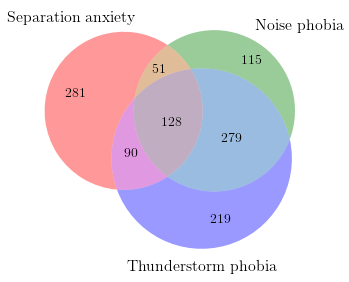

Chi-squared Test of Independence for Thunderstorm phobia, Noise phobia, and Separation anxiety:
chi2 = 285.272663, p = 1.53E-61, dof = 3
The resulting p-value is below the set significance threshold (0.01).


,Thunderstorm phobia,Noise phobia,Separation anxiety
Thunderstorm phobia,1.000000,0.568962,0.211230
Noise phobia,0.568962,1.000000,0.230353
Separation anxiety,0.211230,0.230353,1.000000


In [38]:
# Create a contingency table.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
contingency = pd.crosstab(df[labels[2]], [df[labels[0]], df[labels[1]]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[2]: contingency[0][0][1],
     labels[1]: contingency[1][0][0],
     'Separation-Noise': contingency[1][0][1],
     labels[0]: contingency[0][1][0],
     'Separation-Thunderstorm': contingency[0][1][1],
     'Noise-Thunderstorm': contingency[1][1][0],     
     'All': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
v = venn3(cross_sums, set_labels=[cross_sums.index.values[i] for i in [0, 1, 3]])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x+0.25, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_1')
plt.show()

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s, %s, and %s:' %(labels[0], labels[1], labels[2]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

## 6. Compulsion and Fearful/Anxious Behaviors

Compulsion,0,1
Fear/Anxiety,,
0,2020,280
1,1455,359


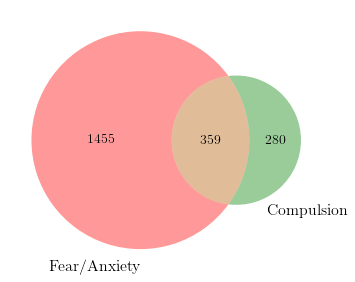

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,Fear/Anxiety,Compulsion
Fear/Anxiety,1.000000,0.104404
Compulsion,0.104404,1.000000


In [39]:
# Create the necessary dataframe.
fields = 'q02_main_2, q02_main_3'
labels = ['Fear/Anxiety', 'Compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

## 7. Aggression and Fearful/Anxious Behavior

### Overall aggression and fearful/anxious behavior:

Fear/Anxiety,0,1
Aggression,,
0,1765,1110
1,535,704


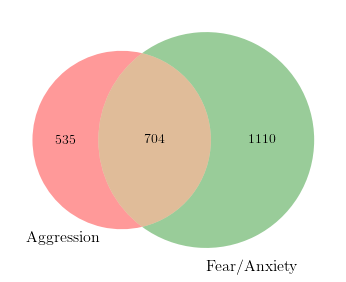

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,Aggression,Fear/Anxiety
Aggression,1.000000,0.168273
Fear/Anxiety,0.168273,1.000000


In [40]:
# Create the necessary dataframe.
fields = 'q02_main_1, q02_main_2'
labels = ['Aggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_2')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

### Owner directed aggression and fearful/anxious behavior:

Fear/Anxiety,0,1
Owner directed aggression,,
0,2198,1620
1,102,194


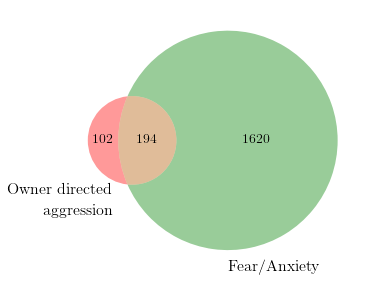

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,Owner directed aggression,Fear/Anxiety
Owner directed\naggression,1.000000,0.120276
Fear/Anxiety,0.120276,1.000000


In [41]:
# Create the necessary dataframe.
fields = 'q03_main_1, q02_main_2'
labels = ['Owner directed\naggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_3')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

### 7.3 Owner directed aggression and separation anxiety:

Separation anxiety,0,1
Owner directed aggression,,
0,3344,474
1,220,76


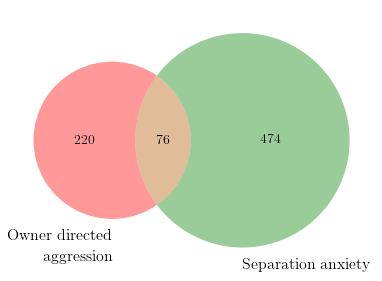

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,Owner directed aggression,Separation anxiety
Owner directed\naggression,1.000000,0.100689
Separation anxiety,0.100689,1.000000


In [42]:
# Create the necessary dataframe.
fields = 'q03_main_1, q04_9'
labels = ['Owner directed\naggression', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_4')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

## 8. Factors Influencing Prevalence and Frequency

### Prevalence ranked by age of onset:

In [43]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('q01_age_months')
labels.append('Age')
fields.append('q01_acq')
labels.append('Evident at Acquisition')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
#df = df[np.isfinite(df[labels[12]])]

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['Age'] < 3)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 3) & (df['Age'] < 6)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 6) & (df['Age'] < 12)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 12) & (df['Age'] < 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Age'] >= 36)].drop(columns=['Age', 'Evident at Acquisition']))
rngs.append(df[(df['Evident at Acquisition'] == 1)].drop(columns=['Age', 'Evident at Acquisition']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))
prevs.append(get_group_prevalence(rngs[2]))
prevs.append(get_group_prevalence(rngs[3]))
prevs.append(get_group_prevalence(rngs[4]))
prevs.append(get_group_prevalence(rngs[5]))

df = pd.DataFrame(index=prevs[0].index, data={'0-3m': prevs[0], '3-6m': prevs[1], '6-12m': prevs[2],
                                              '12-36m': prevs[3], '+36m': prevs[4],
                                              'Evident at Acquisition': prevs[5]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_4') # Exporting will overwrite custom formatting

Behavior problem,0-3m,3-6m,6-12m,12-36m,+36m,Evident at Acquisition
Aggression,45.45,45.28,51.04,60.82,54.71,39.42
Fear/Anxiety,45.45,53.77,51.04,53.22,51.18,67.85
Compulsion,27.27,15.09,18.75,20.47,20.59,20.47
House Soiling,54.55,12.26,14.58,11.11,18.24,27.58
Excessive Barking,9.09,22.64,32.29,26.32,24.12,22.67
Jumping,27.27,37.74,42.19,24.56,17.06,28.76
Mounting/Humping,18.18,16.98,14.58,12.28,4.12,10.15
Consuming Feces,27.27,17.92,21.88,18.13,14.71,17.43
Destructive Behavior,27.27,16.98,16.67,15.20,15.88,17.43
Rolling in Repulsive Material,9.09,11.32,16.15,11.70,15.29,9.14


### Prevalence by gender and neutered status:

In [44]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

intact_male_p = get_group_prevalence(df_intact_male)
neutered_male_p = get_group_prevalence(df_neutered_male)
intact_female_p = get_group_prevalence(df_intact_female)
neutered_female_p = get_group_prevalence(df_neutered_female)

df = pd.DataFrame(index=intact_male_p.index, data={'Intact males': intact_male_p,
                                                   'Castrated males': neutered_male_p,
                                                   'Intact females': intact_female_p,
                                                   'Spayed females': neutered_female_p})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_3') # Exporting will overwrite custom formatting

Behavior problem,Intact males,Castrated males,Intact females,Spayed females
Aggression,19.55,35.61,16.23,29.08
Fear/Anxiety,29.49,45.78,29.87,47.53
Compulsion,10.90,17.30,7.47,16.09
House Soiling,11.22,15.52,9.74,16.03
Excessive Barking,10.26,20.33,11.69,19.35
Jumping,33.33,27.29,32.47,27.39
Mounting/Humping,17.31,13.26,6.82,7.48
Consuming Feces,10.58,17.84,13.31,19.18
Destructive Behavior,11.86,11.89,11.69,11.92
Rolling in Repulsive Material,5.13,11.47,10.39,15.13


### Prevalence by origin:

In [45]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.append('acquisition_source')
labels.append('origin')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}

rngs = []
for i in range(1, 9):
    cnt = i
    if i >= 4:
        cnt += 1
    rngs.append(df[(df['origin'] == cnt)].drop(columns=['origin']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
for j in range(0, 8):
    prevs.append(get_group_prevalence(rngs[j]))

df = pd.DataFrame(index=intact_male_p.index, data={'Rescue': prevs[0], 'Online': prevs[1],
                                                   'Pet store': prevs[2], 'Breeder': prevs[3],
                                                   'Self-bred': prevs[4], 'Family/Friends': prevs[5],
                                                   'Found': prevs[6], 'Other': prevs[7]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_5') # Exporting will overwrite custom formatting

Behavior problem,Rescue,Online,Pet store,Breeder,Self-bred,Family/Friends,Found,Other
Aggression,36.32,35.06,33.33,21.70,19.85,34.69,32.17,28.57
Fear/Anxiety,54.06,40.26,37.25,33.78,20.59,44.61,52.17,39.73
Compulsion,17.80,19.48,33.33,12.30,3.68,16.91,18.26,14.73
House Soiling,18.86,19.48,29.41,9.48,2.94,13.99,18.26,19.64
Excessive Barking,20.09,24.68,29.41,16.15,6.62,21.87,21.74,15.18
Jumping,28.15,40.26,33.33,28.59,19.85,28.86,25.22,26.79
Mounting/Humping,10.41,15.58,15.69,10.59,3.68,9.62,15.65,11.61
Consuming Feces,19.81,15.58,23.53,16.44,13.24,15.74,10.43,14.73
Destructive Behavior,14.83,16.88,11.76,7.78,5.88,13.99,9.57,12.95
Rolling in Repulsive Material,13.04,22.08,11.76,11.70,6.62,11.37,12.17,15.62


### Prevalence by purebred lineage:

In [46]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)
fields.append('purebred')
labels.append('purebred')
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

rngs = []
rngs.append(df[(df['purebred'] == 1)].drop(columns=['purebred']))
rngs.append(df[(df['purebred'] == 0)].drop(columns=['purebred']))

def get_group_prevalence(df):
    df = df.sum().apply(lambda x: (x / len(df.index)) * 100)
    return df.round(2)

prevs = []
prevs.append(get_group_prevalence(rngs[0]))
prevs.append(get_group_prevalence(rngs[1]))

df = pd.DataFrame(index=intact_male_p.index, data={'Purebred': prevs[0], 'Non-purebred': prevs[1]})
df.columns.name = 'Behavior problem'
display(df)
#exportTable(df, 'table_6') # Exporting will overwrite custom formatting

Behavior problem,Purebred,Non-purebred
Aggression,25.87,35.93
Fear/Anxiety,37.60,52.99
Compulsion,14.60,17.06
House Soiling,13.62,17.01
Excessive Barking,16.27,21.36
Jumping,26.00,31.22
Mounting/Humping,9.21,12.25
Consuming Feces,18.12,16.83
Destructive Behavior,9.51,15.26
Rolling in Repulsive Material,11.13,14.39


### Impact of gender on behavior problem prevalence:

In [47]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

def gender_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['gender'] = df['gender'].apply(
    lambda x: gender_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

gender,0,1
behavior problems,,
0,331,268
1,1764,1737


Chi-squared Test of Independence for behavior problems and gender:
chi2 = 4.861002, p = 2.75E-02, dof = 1


,behavior problems,gender
behavior problems,1.000000,0.034433
gender,0.034433,1.000000


### Impact of neutered status on behavior problem prevalence:

In [48]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df[df[labels[1]] != '2']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['neutered'] = df['neutered'].apply(
    lambda x: convert_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

neutered,0,1
behavior problems,,
0,139,458
1,481,3014


Chi-squared Test of Independence for behavior problems and neutered:
chi2 = 35.951010, p = 2.02E-09, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,behavior problems,neutered
behavior problems,1.000000,0.093732
neutered,0.093732,1.000000


### Impact of source of origin on behavior problem prevalence:

In [49]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
#replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
#                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

origin,0,1
behavior problems,,
0,449,146
1,1847,1641


Chi-squared Test of Independence for behavior problems and origin:
chi2 = 104.639735, p = 1.46E-24, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,behavior problems,origin
behavior problems,1.000000,0.160088
origin,0.160088,1.000000


### Impact of purebred status on behavior problem prevalence:

In [50]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def convert_to_binary_response(x):
    x = int(x)
    if x < 1:
        return 0
    return 1

df['behavior problems'] = df['behavior problems'].apply(
    lambda x: convert_to_binary_response(x))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

purebred,0,1
behavior problems,,
0,143,447
1,1580,1888


Chi-squared Test of Independence for behavior problems and purebred:
chi2 = 93.827777, p = 3.44E-22, dof = 1
The resulting p-value is below the set significance threshold (0.01).


,behavior problems,purebred
behavior problems,1.000000,-0.152058
purebred,-0.152058,1.000000


### Number of behavior problems by age range:

In [51]:
# Create the necessary dataframe.
fields = ['q02_score', 'q01_age_months']
labels = ['behavior problems', 'age'] 
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Ranges: 0=0-3m, 1=3-6m, 2=6m-1y, 3=1-3y, 4=3y+, 5=evident at acquisition
rngs = []
rngs.append(df[(df['age'] < 3)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 3) & (df['age'] < 6)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 6) & (df['age'] < 12)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 12) & (df['age'] < 36)].drop(columns=['age']))
rngs.append(df[(df['age'] >= 36)].drop(columns=['age']))

def get_group_mean(df):
    return float(df.mean())

means = []
for i, val in enumerate(rngs):
    means.append(get_group_mean(rngs[i]))
    
df = pd.DataFrame(index=['0-3m', '3-6m', '6-12m', '12-36m', '+36m'], data={'Number of Behavior Problems': means})
df.columns.name = 'Age Range'
display(df)
exportTable(df, 'table_7') # Exporting will overwrite custom formatting

Age Range,Number of Behavior Problems
0-3m,3.181818
3-6m,2.839623
6-12m,3.109375
12-36m,2.830409
+36m,2.511765


### Impact of age on prevalence:

In [52]:
fields = 'q02_score, q01_age_months'
labels = ['behavior problems', 'age']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)
display(df.describe())

def convert_to_binary_response(x, y):
    x = float(x)
    if x < y:
        return 0
    return 1

df['age'] = df['age'].apply(lambda x: convert_to_binary_response(x, 12))
df['behavior problems'] = df['behavior problems'].apply(lambda x: convert_to_binary_response(x, 1))
contingency = pd.crosstab(df[labels[0]], df[labels[1]], margins=False)
display(contingency)

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s and %s:' %(labels[0], labels[1]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)
display(df.corr())

,behavior problems,age
count,650.000000,650.000000
mean,2.836923,25.129385
std,1.807668,29.085864
min,0.000000,1.000000
25%,1.000000,6.000000
50%,2.000000,12.000000
75%,4.000000,36.000000
max,11.000000,180.000000


age,0,1
behavior problems,,
0,4,5
1,305,336


Chi-squared Test of Independence for behavior problems and age:
chi2 = 0.035031, p = 8.52E-01, dof = 1


,behavior problems,age
behavior problems,1.000000,-0.007341
age,-0.007341,1.000000


## 8b. Impact on Number of Behavior Problems

### Impact of age on number of behavior problems:

In [53]:
# Did not implement
# fields = 'q02_score, q01_age_months'
# labels = ['behavior problems', 'age']
# df = createStringDataFrame(DOG_TABLE, fields, labels)
# df = df[df[labels[1]] != '']
# df = df.apply(pd.to_numeric)
# display(df.describe())

### Impact of gender on number of behavior problems:

In [54]:
fields = 'q02_score, dog_sex'
labels = ['behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

males = df[(df['gender'] == 1)].drop(columns=['gender'])
display(males.describe())
females = df[(df['gender'] == 2)].drop(columns=['gender'])
display(females.describe())
ttest_ind(males, females, equal_var=False)

,behavior problems
count,2005.000000
mean,2.316209
std,1.838207
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,2095.000000
mean,2.220525
std,1.812368
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,10.000000


Ttest_indResult(statistic=array([1.67760178]), pvalue=array([0.09350138]))

In [55]:
fields = 'q02_score, dog_spayed'
labels = ['behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

neutered = df[(df['neutered'] == 1)].drop(columns=['neutered'])
display(neutered.describe())
intact = df[(df['neutered'] == 0)].drop(columns=['neutered'])
display(intact.describe())
ttest_ind(neutered, intact, equal_var=False)

,behavior problems
count,3472.000000
mean,2.358583
std,1.835858
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,620.000000
mean,1.756452
std,1.675744
min,0.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,10.000000


Ttest_indResult(statistic=array([8.11917428]), pvalue=array([1.52691395e-15]))

In [56]:
fields = 'q02_score, purebred'
labels = ['behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)


purebred = df[(df['purebred'] == 1)].drop(columns=['purebred'])
display(purebred.describe())
notpure = df[(df['purebred'] == 0)].drop(columns=['purebred'])
display(notpure.describe())
ttest_ind(notpure, purebred, equal_var=False)

,behavior problems
count,2335.000000
mean,2.016702
std,1.752993
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


,behavior problems
count,1723.000000
mean,2.617528
std,1.869890
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


Ttest_indResult(statistic=array([10.38788185]), pvalue=array([6.35298174e-25]))

In [57]:
fields = 'q02_score, acquisition_source'
labels = ['behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df.apply(pd.to_numeric)

def rescue_to_binary_response(x):
    x = int(x)
    if x != 1:
        return 0
    return 1

df['origin'] = df['origin'].apply(lambda x: rescue_to_binary_response(x))
rescue = df[(df['origin'] == 1)].drop(columns=['origin'])
display(rescue.describe())
nonrescue = df[(df['origin'] == 0)].drop(columns=['origin'])
display(nonrescue.describe())
ttest_ind(rescue, nonrescue, equal_var=False)

,behavior problems
count,1787.000000
mean,2.595971
std,1.825275
min,0.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


,behavior problems
count,2296.000000
mean,2.017857
std,1.788643
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


Ttest_indResult(statistic=array([10.12868587]), pvalue=array([8.24413961e-24]))

## 9. Heatmaps

### Category reference chart:

In [58]:
# Construct lists.
cat_dict = {}
for cat, subdict in FR.labels.items():
    for key, value in  subdict.items():
        cat_dict[key[0]] = cat
        break

s = pd.Series(cat_dict)
df = pd.DataFrame(index=s.index, data={'Category':s.values})
df.columns.name = 'Index'
display(df)
exportTable(df, 'table_category_reference')

Index,Category
A,Aggression
B,Fear/Anxiety
C,Compulsion
D,House Soiling
E,Excessive Barking
F,Jumping
G,Mounting/Humping
H,Consuming Feces
I,Destructive Behavior
J,Rolling in Repulsive Material


### Category heatmap:

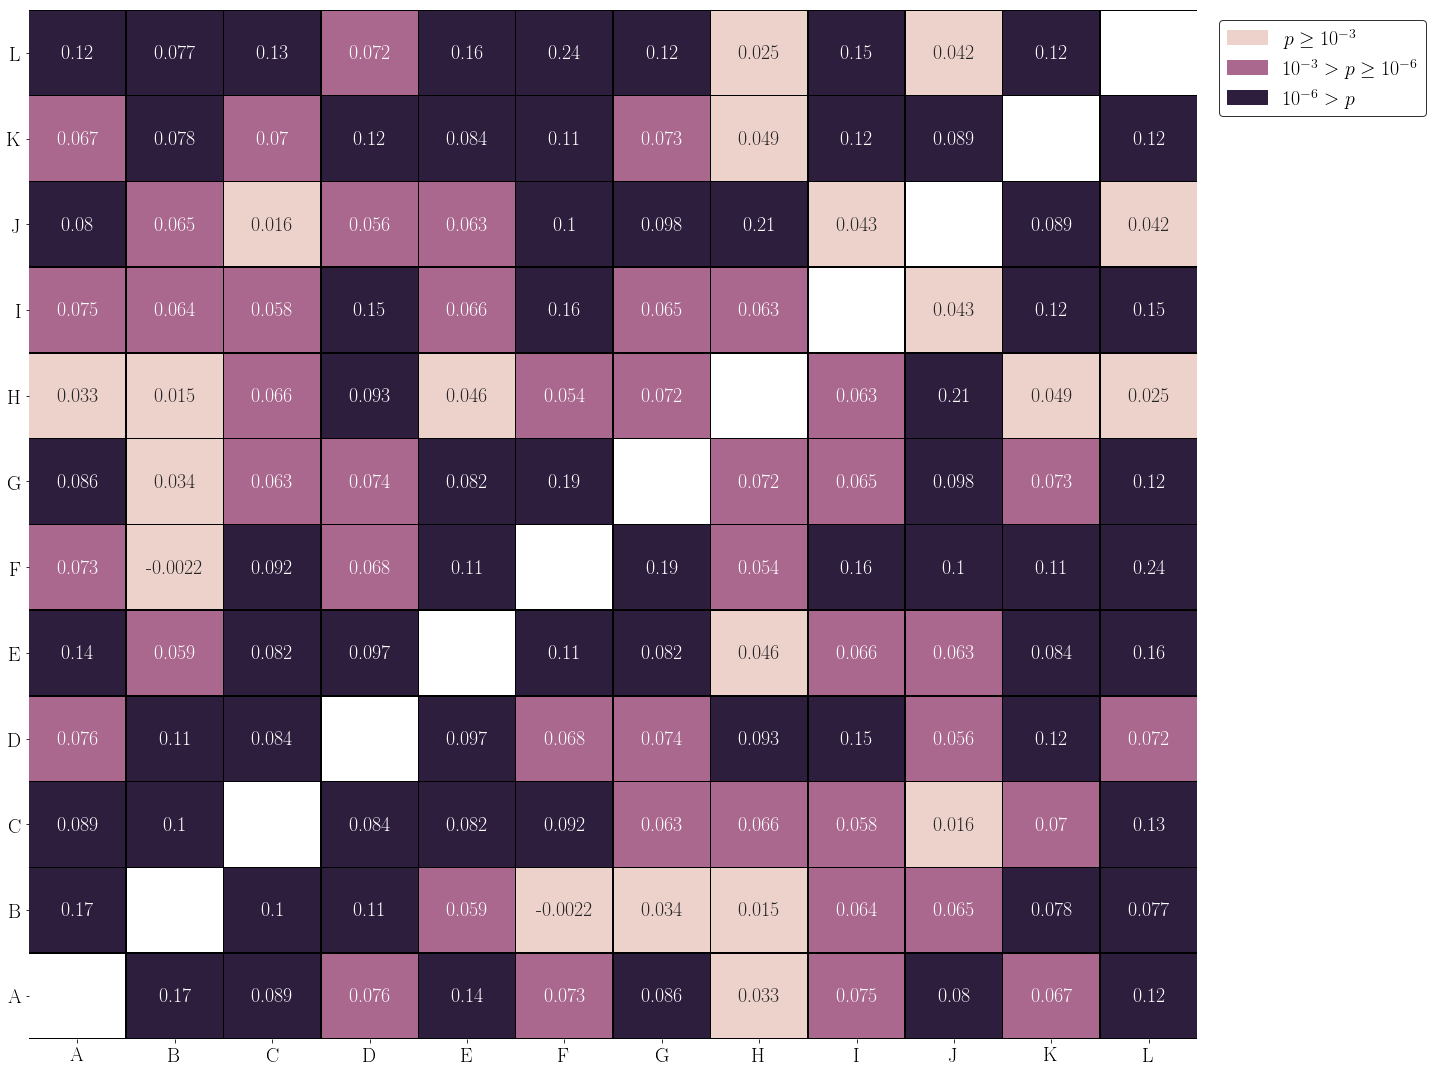

In [96]:
if CATEGORY_MATRIX.empty:
    CATEGORY_MATRIX = createCategoryMatrix()
    
# Create a new dataframe with categories:
df = CATEGORY_MATRIX.applymap(lambda row: get_significance_category(row))
df_corr = createCorrelationMatrix()

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.cubehelix_palette(n_colors=3)
ax = sns.heatmap(data=df, ax=ax, cmap=ListedColormap(cmap), linewidths=0.5, linecolor='black',
                 cbar=False, mask=df.isnull(), annot=df_corr, annot_kws={"size": 20})
plt.xticks(rotation=0, fontsize=20)
plt.yticks(rotation=0, fontsize=20)
ax.invert_yaxis()
import matplotlib.patches as mpatches
patch_1 = mpatches.Patch(color=cmap[0], label='$p\geq10^{-3}$')
patch_2 = mpatches.Patch(color=cmap[1], label='$10^{-3}>p\geq10^{-6}$')
patch_3 = mpatches.Patch(color=cmap[2], label='$10^{-6}>p$')
legend = plt.legend(handles=[patch_1, patch_2, patch_3], bbox_to_anchor=(1.01, 1), loc=2, fontsize=20)
legend.get_frame().set_edgecolor('black')
exportFigure(fig, 'figure_6')
plt.show()

### Questionnaire heatmap: